Работу выполнил Данил Исламов (Stepik ID: 274397404)

# Autoencoders. Main part

## Part 1. Vanilla Autoencoder (2 балла)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from time import time
from time import sleep
from IPython.display import clear_output
from copy import deepcopy
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Prepare the data


This version of autoencoder will be trained on the "Labeled Faces in the Wild" (LFW) dataset

In [ ]:
# Here I stored all the files for the project; uncomment and change the path, if necessary

# os.chdir('/content/drive/MyDrive/DLS_Autoencoders_project')
# !pwd

/content/drive/MyDrive/DLS_Autoencoders_project


In [ ]:
# The following codeline fetches two datasets: images, usable for autoencoder training, and attributes.
# The attributes will be required for the final part of the assignment
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, downloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
data = np.array(data, np.float32)

In [ ]:
x_train, x_val = train_test_split(data, test_size=0.2, shuffle=True)

In [ ]:
len(x_train)

10514

Look at the random images from train dataset to check, whether they were downloaded correctly

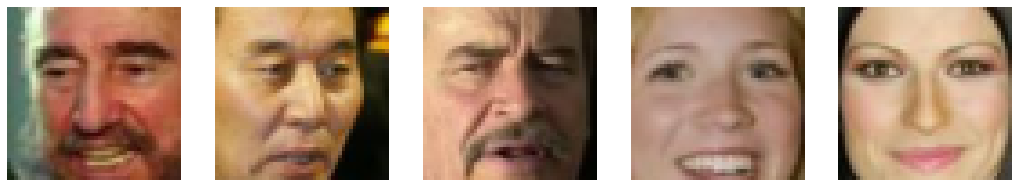

In [ ]:
inds = np.random.uniform(0, len(x_train), size=5)

plt.figure(figsize=(18, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_train[int(inds[i])])

Create dataloaders for training and validation

In [ ]:
batch_size = 30

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(x_train, 3, 1), np.rollaxis(x_train, 3, 1))), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(x_val, 3, 1))), 
                     batch_size=batch_size, shuffle=True)

### Architecture

Here I will implement the Convolutional Autoencoder with the fully-connected bottleneck

Below you can see a number of feature maps obtained from the last convolutional layer of the encoder. However, there is a fully-connected bottleneck between the encoder and the decoder, so the shape of each latent code would be (dim_code * h * w)

In [ ]:
dim_code = 128

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=dim_code, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim_code),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.bottleneck1 = nn.Sequential(
            nn.Linear(in_features=dim_code*6*6, out_features=dim_code*6*6),
            nn.BatchNorm1d(dim_code*6*6),
            nn.ReLU())
        
        self.bottleneck2 = nn.Sequential(
            nn.Linear(in_features=dim_code*6*6, out_features=dim_code*6*6),
            nn.BatchNorm1d(dim_code*6*6),
            nn.ReLU())

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=dim_code, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, stride=2),
            nn.Sigmoid())


    def forward(self, x):
        x = self.encoder(x)
        x = torch.reshape(x, (-1, dim_code*6*6))
        latent_code = self.bottleneck1(x)
        x = self.bottleneck2(latent_code)
        x = torch.reshape(x, (-1, dim_code, 6, 6))
        reconstruction = self.decoder(x)
        return reconstruction, latent_code
    
    def encode(self, x):
        self.eval()
        x = self.encoder(x)
        x = torch.reshape(x, (-1, dim_code*6*6))
        latent_code = self.bottleneck1(x)
        return latent_code
    
    def decode(self, x):
        self.eval()
        x = self.bottleneck2(x)
        x = torch.reshape(x, (-1, dim_code, 6, 6))
        reconstruction = self.decoder(x)
        return reconstruction

Function, useful for training of the autoencoder. It prints the loss on validation dataset and shows the autoencoder's outputs from validation batch after every epoch. The function returns the history of losses on the train dataset and on the validation dataset

In [ ]:
def train_vanilla(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, Y_val = next(iter(data_val))

    loss_tr = []
    loss_val = []
    lcs = []

    model.train()
    for epoch in range(epochs):

        print(f'* Epoch {epoch+1}/{epochs}')

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            if X_batch.size()[0] < batch_size:
              continue
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred, _ = model(X_batch.to(device))
            loss = loss_fn(Y_pred, Y_batch.to(device)) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            if epoch % 10 == 9 and scheduler:
                scheduler.step()

            # calculate loss to show the user and save
            avg_loss += loss / len(data_tr)
        
        loss_tr.append(avg_loss)

        # show intermediate results
        model.eval()
        Y_hat = model(X_val.to(device))[0]
        Y_hat = Y_hat.detach()
        cur_loss = loss_fn(Y_hat, Y_val.to(device))
        loss_val.append(cur_loss)

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 4))
        for k in range(10):
            
            plt.subplot(2, 10, k+1)
            plt.imshow((np.rollaxis(X_val[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
            plt.title('Input')
            plt.axis('off')

            plt.subplot(2, 10, k+11)
            plt.imshow((np.rollaxis(Y_hat[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
            plt.title('Output')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, cur_loss))
        plt.show()

    return loss_tr, loss_val

### Training

Now, choose loss and optimizer, and train the autoencoder 

In [ ]:
criterion = nn.BCELoss()
autoencoder = Autoencoder().to(device)
opt = optim.AdamW(autoencoder.parameters())

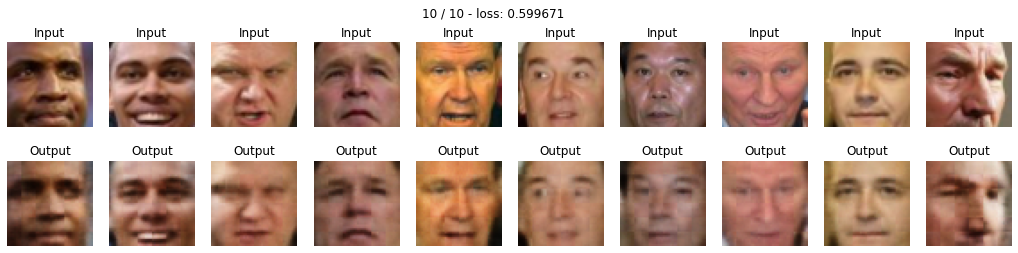

In [ ]:
 loss_tr, loss_val = train_vanilla(autoencoder, opt, criterion, 10, data_tr, data_val)

The graph of losses

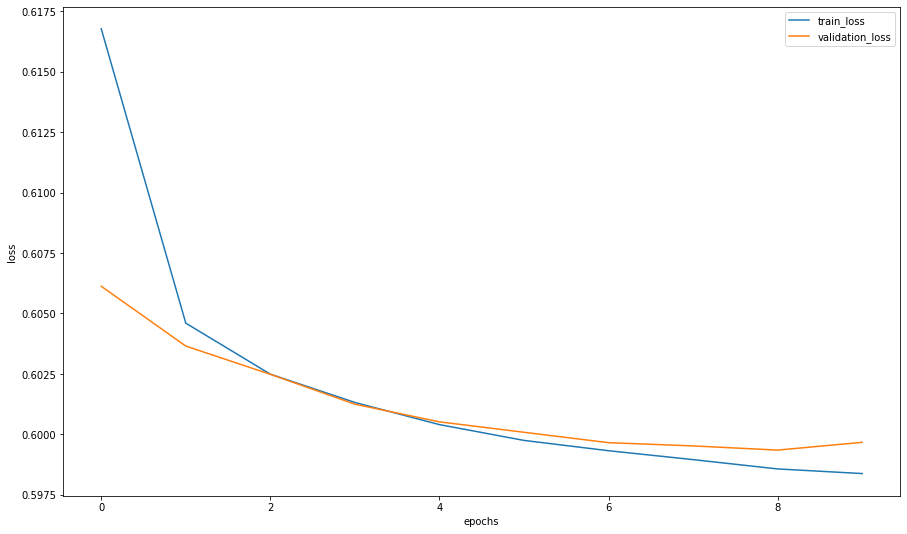

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_val, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Choose some images from validation dataset and show autoencoder's outputs on them

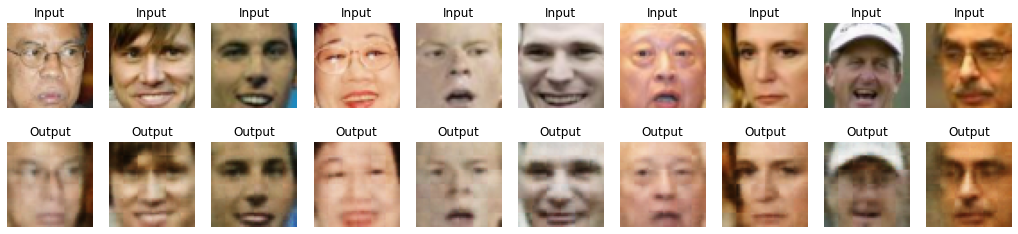

In [ ]:
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(x_val, 3, 1))), 
                     batch_size=batch_size, shuffle=True)
X = next(iter(data_val))[0].to(device)

autoencoder.eval()
Y = autoencoder(X)[0].detach()

plt.figure(figsize=(18, 4))
for k in range(10):
            
    plt.subplot(2, 10, k+1)
    plt.imshow((np.rollaxis(X[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.title('Input')
    plt.axis('off')

    plt.subplot(2, 10, k+11)
    plt.imshow((np.rollaxis(Y[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.title('Output')
    plt.axis('off')

Save the autoencoder's parameters, they will be useful in the bonus tasks

In [ ]:
vanilla_AE_params = autoencoder.state_dict()

### Generation

Now we will try to reconstruct the new faces from the random vectors, using autoencoder's decoder. To improve the quality of generated images, it can be worthwile to make their distribution similar to the real images' distribution.

Firstly, we will get the list, containing the latent vectors of all images from the whole dataset. Then we will calculate the mean and the std of every component of those latent vectors. This way, both the mean and the std would be an arrays of the same size as the latent vectors.

Then, we will generate random vectors component-by-component, using the appropriate mean and std as the parameters

In [ ]:
data_gen = DataLoader(np.rollaxis(data, 3, 1), batch_size=batch_size, shuffle=True, num_workers=2)
lcs = []

for batch in data_gen:
    X = batch
    X = X.to(device)

    autoencoder.eval()
    latent_code = autoencoder.encode(X).detach()
    lcs.append(latent_code)

In [ ]:
lcs = torch.cat(lcs)

In [ ]:
mean = torch.mean(lcs, dim=0)
std = torch.std(lcs, dim=0)

In [ ]:
print(mean.size())
print(std.size())

torch.Size([4608])
torch.Size([4608])


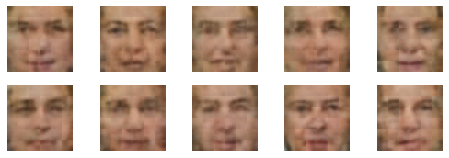

In [ ]:
z = torch.randn(10, *mean.size()).to(device)
z = z * std + mean

autoencoder.eval()
output = autoencoder.decode(z).detach()

plt.figure(figsize=(8, 7))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow((np.rollaxis(output[i].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.axis('off')
plt.show()

Well, the generated faces are far from perfection, as the real images' latent code could have some features that mean and std could not catch. However, I think that the result is quite good, as the generated images are similar enough to faces

In [ ]:
del lcs
torch.cuda.empty_cache()

### Drawing smiles

Find the images of people with the highest "smile rate" and get their indices

In [ ]:
top_smile = attrs.sort_values(by='Smiling', ascending=False)
smile_ix = top_smile.head(20).index
print(top_smile.head())
print(smile_ix)

           Male     Asian  ... Wearing Necktie Wearing Necklace
8643   -2.51113  -1.76019  ...        -0.59929          1.11155
1816  -0.626934 -0.472967  ...       -0.335121          0.72465
13034  -1.52268 -0.454004  ...        -1.13999          1.54333
5624   -2.65704  -2.05056  ...       -0.975989         0.637409
1045   -1.94055 -0.583674  ...        -1.58417         0.964526

[5 rows x 73 columns]
Int64Index([ 8643,  1816, 13034,  5624,  1045,  4681,  6139, 11797,  1359,
             2031,  1955,  9004,   459,  6166,   682,   983,  9165,  9005,
             1605, 12606],
           dtype='int64')


Find the images of people with the lowest "smile rate" and get their indices

In [ ]:
reverse_top = attrs.sort_values(by='Smiling')
sad_ix = reverse_top.head(20).index
print(reverse_top.head())
print(sad_ix)

           Male     Asian  ... Wearing Necktie Wearing Necklace
11571   2.13624 -0.882146  ...       -0.412097         -1.84327
1234   0.954913 -0.983356  ...       -0.104821         -1.22919
7506    1.43308   -1.0669  ...       -0.110776        -0.868778
5458  -0.188162 -0.647783  ...        0.464435        -0.972584
7065    1.65926 -0.886879  ...       -0.181398        -0.587911

[5 rows x 73 columns]
Int64Index([11571,  1234,  7506,  5458,  7065, 11912,  1654,   471,  8410,
             8596, 12688,  1432, 10097, 10506,  9114,  6321,  3798,  8092,
             2390,  6019],
           dtype='int64')


Get the latent representations of the "most smiling" people and the "least smiling" ones. Then calculate the mean latent vector for both groups. The difference of those vectors (taking the order into account) can be considered as the "vector of smile"

In [ ]:
smile_batch = []
for i in smile_ix:
    smile_batch.append(data[i])
smile_batch = np.array(smile_batch, np.float32)
smile_batch = torch.tensor(np.rollaxis(smile_batch, 3, 1))

sad_batch = []
for i in sad_ix:
    sad_batch.append(data[i])
sad_batch = np.array(sad_batch, np.float32)
sad_batch = torch.tensor(np.rollaxis(sad_batch, 3, 1))

In [ ]:
smile_lc = autoencoder(smile_batch.to(device))[1].detach().cpu()
aver_smile = np.mean(smile_lc.numpy(), axis=0)

sad_lc = autoencoder(sad_batch.to(device))[1].detach().cpu()
aver_sad = np.mean(sad_lc.numpy(), axis=0)

smile_vec = aver_smile - aver_sad

In [ ]:
smile_vec.shape

(4608,)

Make sad people smile!

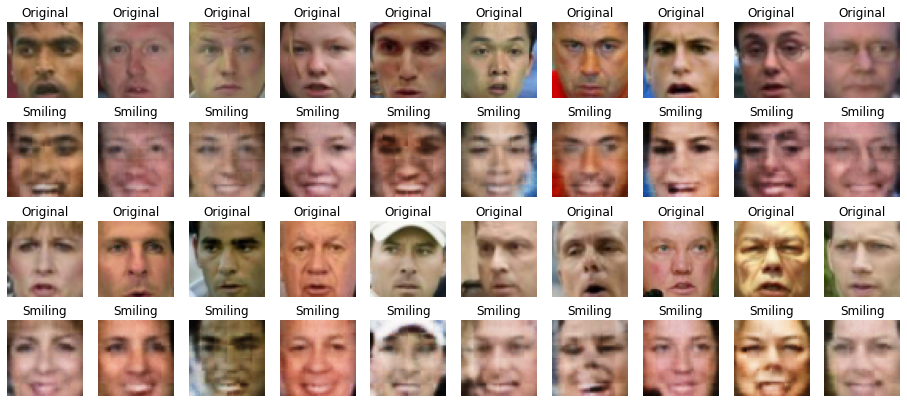

In [ ]:
antisad = sad_lc + smile_vec
output = autoencoder.decode(antisad.to(device)).detach().cpu()

plt.figure(figsize=(16, 7))
n = 0
for i in range(20):
    plt.subplot(4, 10, i + 1 + 10*n)
    plt.title('Original')
    plt.imshow(data[sad_ix[i]])
    plt.axis('off')
    
    plt.subplot(4, 10, i + 11 + 10*n)
    plt.title('Smiling')
    plt.imshow((np.rollaxis(output[i].numpy(), 0, 3) * 255).astype('uint8'))
    plt.axis('off')

    if i == 9:
       n = 1    
plt.show()

The result is creepy for some images, but the autoencoder is not perfect, and the samples of images were very small, so I think the job is done

## Part 2. Variational Autoencoder (3 балла) 

### Prepare the data

This version of autoencoder will be trained on the MNIST dataset

In [ ]:
batch_size = 30

In [ ]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(root='./MNIST', train=True, 
                                      download=True, transform=transforms.ToTensor())
data_tr = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

val_set = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                     download=True, transform=transforms.ToTensor())
data_val = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)


### Architecture

Here I will implement the Convolutional Variational Autoencoder with the fully connected bottleneck. It would calculate 2 parameters-vectors $\mu$ and $\sigma$ — well, actually, $\log(\sigma)$, but this does not change the idea — and then generate the latent code component-by-component from $\mathcal{N}(\mu,\,\sigma^{2})$, and decode it

The dim_code sets the number of feature maps obtained from the last convolutional layer of the encoder, just as before

In [ ]:
dim_code = 256

In [ ]:
class VAE(nn.Module):
    def __init__(self):

        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=dim_code, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim_code),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.mu = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=dim_code),
            nn.BatchNorm1d(dim_code))

        self.logsigma = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=dim_code),
            nn.BatchNorm1d(dim_code))
        
        self.bottleneck1 = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=dim_code),
            nn.BatchNorm1d(dim_code),
            nn.ReLU())
        
        self.bottleneck2 = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=dim_code),
            nn.BatchNorm1d(dim_code),
            nn.ReLU())

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=dim_code, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid())

    def encode(self, x):
        self.eval()
        x = self.encoder(x)
        x = torch.reshape(x, (-1, dim_code))
        x = self.bottleneck1(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = torch.exp(0.5 * logsigma)
            z = torch.randn_like(mu).to(device)
            z = z * sigma + mu
            return z
        else:    
            return mu
    
    def decode(self, z):
        self.eval()
        z = self.bottleneck2(z)
        z = torch.reshape(z, (-1, dim_code, 1, 1))
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        x = self.encoder(x)
        x = torch.reshape(x, (-1, dim_code))
        x = self.bottleneck1(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        x = self.gaussian_sampler(mu, logsigma)
        x = self.bottleneck2(x)
        x = torch.reshape(x, (-1, dim_code, 1, 1))
        reconstruction = self.decoder(x)
        return mu, logsigma, reconstruction

Train function; returns histories of losses on the train and the validation datasets

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val = next(iter(data_val))[0].to(device)

    loss_tr = []
    loss_val = []

    model.train()
    for epoch in range(epochs):
        tic = time()
        print(f'* Epoch {epoch+1}/{epochs}')

        avg_loss = 0
        model.train()  # train mode
        for batch in data_tr:
            X_batch = batch[0].to(device)
            if X_batch.size()[0] < batch_size:
              continue
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            mu, logsigma, Y_pred = model(X_batch.to(device))
            
            loss = loss_fn(X_batch.to(device), mu, logsigma, Y_pred.to(device)) # forward-pass
            loss.backward() # backward-pass
            
            opt.step() # update weights
            if epoch % 10 == 9 and scheduler:
                scheduler.step()

            # calculate loss to show the user and save
            avg_loss += loss / len(data_tr)
        
        loss_tr.append(avg_loss)
        toc = time()
        
        # show intermediate results
        model.eval() 
        mu, logsigma, Y_hat = model(X_val.to(device))
        Y_hat = Y_hat.detach()
        mu = mu.detach()
        logsigma = logsigma.detach()
        cur_loss = loss_fn(X_val, mu, logsigma, Y_hat)
        loss_val.append(cur_loss)

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 4))
        for k in range(10):
            
            plt.subplot(2, 10, k+1)
            plt.imshow(X_val[k][0].to('cpu').numpy(), cmap='gray')
            plt.title('Input')
            plt.axis('off')

            plt.subplot(2, 10, k+11)
            plt.imshow(Y_hat[k][0].to('cpu').numpy(), cmap='gray')
            plt.title('Output')
            plt.axis('off')

        plt.suptitle(f'{epoch+1} / {epochs} - loss: {cur_loss}, time: {toc - tic} sec')
        plt.show()

    return loss_tr, loss_val

### Loss function

The loss will consist of 2 parts: BCE for the similarity of inputs and outputs, and KL-divergence to make the latent codes' distribution closer to standard normal one. 

It was empirically found that the weight of KL-loss should be much lower than the BCE's one. So, I will use the provided coefficient <br/>($\frac{1}{15*28*28}$), as the model showed best results on reconstruction and generation with that certain value

In [ ]:
def KL_divergence(mu, logsigma):
    return torch.sum(mu ** 2 + torch.exp(logsigma) - logsigma - torch.ones_like(mu))/15/28/28

def log_likelihood(x, reconstruction):
    bce = nn.BCELoss()
    return bce(reconstruction, x)

def loss_vae(x, mu, sigma, reconstruction):
    return KL_divergence(mu, sigma) + log_likelihood(x, reconstruction)

### Training

In [ ]:
criterion = loss_vae
autoencoder = VAE().to(device)
opt = optim.AdamW(autoencoder.parameters(), lr=5e-4)

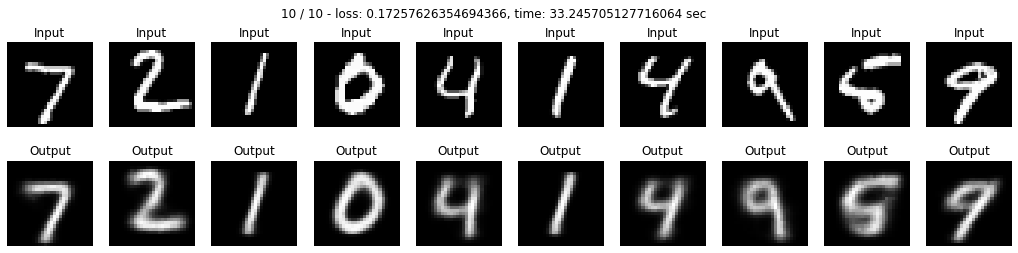

In [ ]:
loss_tr, loss_val = train(autoencoder, opt, criterion, 10, data_tr, data_val)

The graph of losses

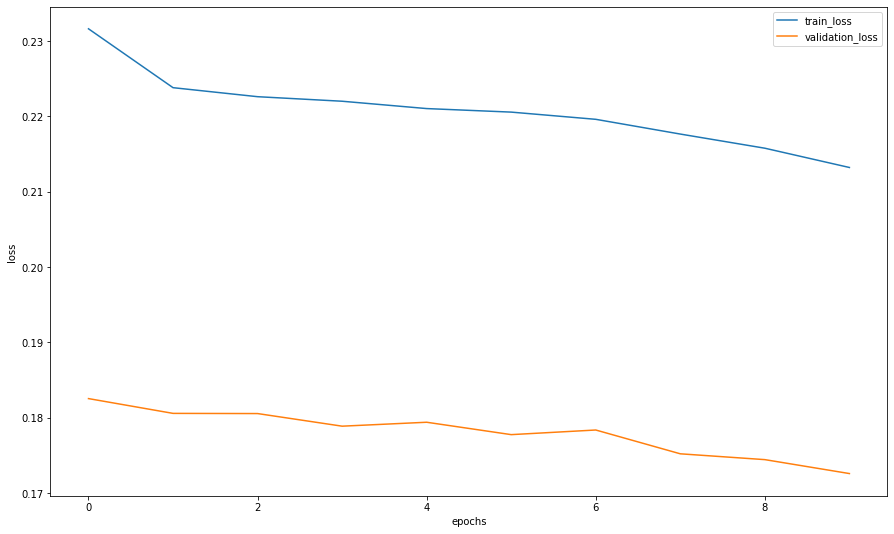

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_val, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Choose some images from validation dataset and show autoencoder's outputs on them

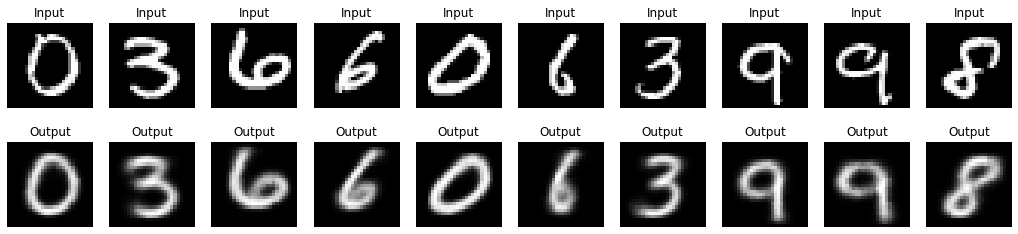

In [ ]:
data_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
X = next(iter(data_val))[0]

autoencoder.eval()
Y = autoencoder(X.to(device))[2].detach().to('cpu')

plt.figure(figsize=(18, 4))
for k in range(10):
            
    plt.subplot(2, 10, k+1)
    plt.imshow(X[k][0].numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')

    plt.subplot(2, 10, k+11)
    plt.imshow(Y[k][0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

### Generation

Now we will try to generate new images from the random vectors, using autoencoder's decoder.

As the KL-divergence should make the latent representations of the images closer to the standard normal distribution, I think that the generation from $\mathcal{N}(0,\,1)$ should make sense. Nevertheless, we will also get the lists of all mu and sigma obtained from the whole dataset, so the approach from the Part 1 still can be applied

In [ ]:
whole_MNIST = train_set + val_set
data_gen = DataLoader(whole_MNIST, batch_size=batch_size, shuffle=True, num_workers=2)
mu_lst = []
logsigma_lst = []

for batch in data_gen:
    X = batch[0]
    X = X.to(device)

    autoencoder.eval()
    mu, logsigma = autoencoder.encode(X)
    
    mu_lst.append(mu.detach())
    logsigma_lst.append(logsigma.detach())

In [ ]:
mean = torch.mean(torch.cat(mu_lst), dim=0)
logsigma = torch.mean(torch.cat(logsigma_lst), dim=0)
std = torch.exp(0.5 * logsigma)

In [ ]:
print(mean.size())
print(logsigma.size())

torch.Size([256])
torch.Size([256])


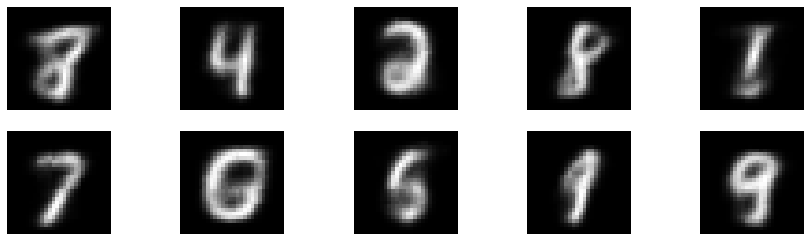

In [ ]:
z = torch.randn(10, *mean.size()).to(device)
# Uncomment the below to use the mean mu and sigma of the train dataset as the 
# parameters of distribution
# z = z * std + mean

autoencoder.eval()
output = autoencoder.decode(z.to(device)).detach().cpu() # <скормите z декодеру>

plt.figure(figsize=(15, 11))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(output[i][0], cmap='gray')
    plt.axis('off')
plt.show()

Again, I cannot say that the generation is good, though some numbers are recognizable. However, if the weight of KL loss would be increased, the reconstruction would be much worse, and the generation would create almost the same image (that does not remind any number) for all random vectors. So, as for me, this result is a good traid-off between quality of generation and reconstruction

In [ ]:
del mu_lst, logsigma_lst
torch.cuda.empty_cache()

### Distribution of latent representations

Now we will get the latent representations of all the images from validation dataset; transform them into the 2-dimensional vectors, using TSNE, and put all these points on the scatter plot to look at their distribution (considering classes of images)

Get the latent codes

In [ ]:
data_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
latent_codes = []
labels = []

for batch in data_val:
    X, label = batch
    X = X.to(device)

    autoencoder.eval()
    latent_code = autoencoder.encode(X)[0].detach().to('cpu').numpy()
    for v in latent_code:
      latent_codes.append(v)

    for l in label:
      labels.append(l.item())

Transform them into the 2-dimensional vectors

In [ ]:
points = TSNE().fit_transform(latent_codes)

Create dictionary, containing classes and all the points, corresponding to those classes 

In [ ]:
clusters = {i: [] for i in range(10)}
for i, l in enumerate(labels):
    clusters[l].append(points[i])

Visualize

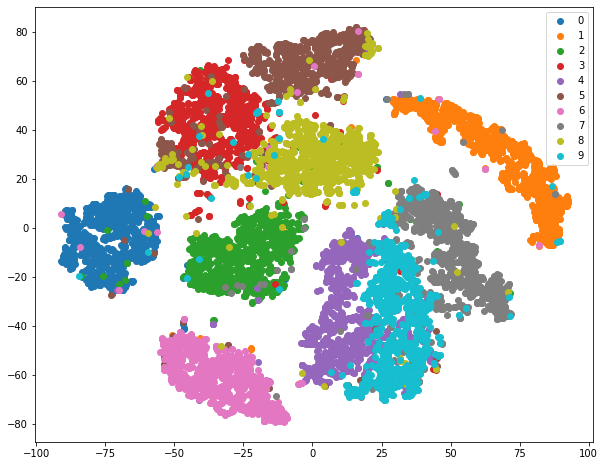

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter([p[0] for p in clusters[i]], [p[1] for p in clusters[i]], label=i)
plt.legend(loc='best')

It is seen that some of the classes are quite close one to another, however, there are still a lot of empty space between other classes. It can mean that the autoencoder would not be able to generate something similar to the picture of number, if the random latent vector would fall somewhere into empty space. The KL-divergence loss should be able to solve this problem, but, as I explained before, increasing of its weight did not bring me any better results

## Part 3. Conditional VAE (2 балла)


Now I will implement the Conditional VAE — the version of VAE, able to generate the the images of the certain class. This autoencoder will be trained on the MNIST dataset

### Architecture

As it was said, the Conditional VAE is based on the simple VAE, so I will use the same architecture with little changes: before going to the bottleneck, feature map will be concatenated with the one-hot-encoded vector of class, so the autoencoder should be able to receive that vector and work with it. Also, the same OHE-vector of class will be concatenated to the latent representation of the image — the same story 

In [ ]:
class CondVAE(VAE):
    def __init__(self):
        super().__init__()
        
        self.bottleneck1 = nn.Sequential(
            nn.Linear(in_features=dim_code*1*1 + 10, out_features=dim_code*1*1),
            nn.BatchNorm1d(dim_code*1*1),
            nn.ReLU())
        
        self.bottleneck2 = nn.Sequential(
            nn.Linear(in_features=dim_code*1*1 + 10, out_features=dim_code*1*1),
            nn.BatchNorm1d(dim_code*1*1),
            nn.ReLU())
    
    def encode(self, x, label):
        self.eval()
        x = self.encoder(x)
        x = torch.reshape(x, (-1, dim_code*1*1))
        x = torch.cat((x, label), dim=1)
        x = self.bottleneck1(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma
    
    
    def decode(self, x, label):
        self.eval()
        x = torch.cat((x, label), dim=1)
        x = self.bottleneck2(x)
        x = torch.reshape(x, (-1, dim_code, 1, 1))
        reconstruction = self.decoder(x)
        return reconstruction

    def forward(self, x, label):
        x = self.encoder(x)
        x = torch.reshape(x, (-1, dim_code*1*1))
        x = torch.cat((x, label), dim=1)
        x = self.bottleneck1(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        x = self.gaussian_sampler(mu, logsigma)
        x = torch.cat((x, label), dim=1)
        x = self.bottleneck2(x)
        x = torch.reshape(x, (-1, dim_code, 1, 1))
        reconstruction = self.decoder(x)
        return mu, logsigma, reconstruction

Train function; almost the same as for VAE, but this one also encodes class label and gives it to the encoder

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, lab_val = next(iter(data_val))
    # Encoding label of the image
    lab_val = F.one_hot(lab_val, num_classes=10)

    loss_tr = []
    loss_val = []

    model.train()
    for epoch in range(epochs):
        tic = time()
        print(f'* Epoch {epoch+1}/{epochs}')

        avg_loss = 0
        model.train()  # train mode
        for batch in data_tr:
            X_batch, lab_batch = batch
            lab_batch = F.one_hot(lab_batch, num_classes=10)
            if X_batch.size()[0] < batch_size:
              continue
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            mu, logsigma, Y_pred = model(X_batch.to(device), lab_batch.to(device))
            
            loss = loss_fn(X_batch.to(device), mu, logsigma, Y_pred.to(device)) # forward-pass
            loss.backward() # backward-pass
            
            opt.step() # update weights
            if epoch % 10 == 9 and scheduler:
                scheduler.step()

            # calculate loss to show the user and save
            avg_loss += loss / len(data_tr)
        
        loss_tr.append(avg_loss)
        toc = time()

        # show intermediate results
        model.eval()
        mu, logsigma, Y_hat = model(X_val.to(device), lab_val.to(device))
        Y_hat = Y_hat.detach()
        mu = mu.detach()
        logsigma = logsigma.detach()
        cur_loss = loss_fn(X_val.to(device), mu, logsigma, Y_hat)
        loss_val.append(cur_loss)

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 4))
        for k in range(10):
            
            plt.subplot(2, 10, k+1)
            plt.imshow(X_val[k][0].to('cpu').numpy(), cmap='gray')
            plt.title('Input')
            plt.axis('off')

            plt.subplot(2, 10, k+11)
            plt.imshow(Y_hat[k][0].to('cpu').numpy(), cmap='gray')
            plt.title('Output')
            plt.axis('off')

        plt.suptitle(f'{epoch+1} / {epochs} - loss: {cur_loss}, time: {toc - tic} sec')
        plt.show()

    return loss_tr, loss_val

Loss function stays the same, except for the KL-divergence's coefficient — now it will be $\frac{1}{10*28*28}$, as the practice showed, it is the best choice (among my experiments, of course)

In [ ]:
def KL_divergence(mu, logsigma):
    # часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    return torch.sum(mu ** 2 + torch.exp(logsigma) - logsigma - torch.ones_like(mu))/10/28/28

def log_likelihood(x, reconstruction):
    # часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    bce = nn.BCELoss()
    return bce(reconstruction, x)

def loss_vae(x, mu, sigma, reconstruction):
    return KL_divergence(mu, sigma) + log_likelihood(x, reconstruction)

### Training

In [ ]:
criterion = loss_vae
autoencoder = CondVAE().to(device)
opt = optim.AdamW(autoencoder.parameters(), lr=1e-4)

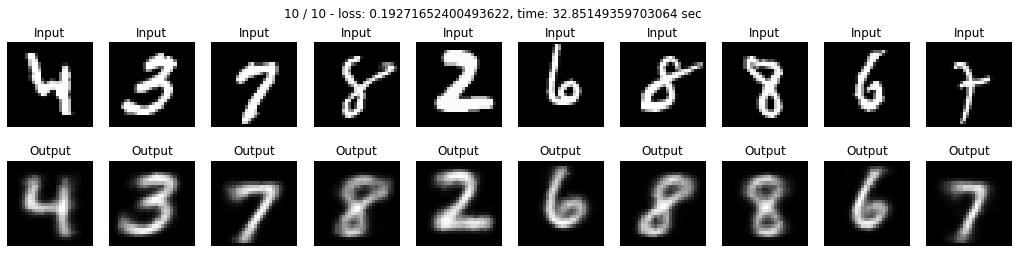

In [ ]:
loss_tr, loss_val = train(autoencoder, opt, criterion, 10, data_tr, data_val)

The graph of losses

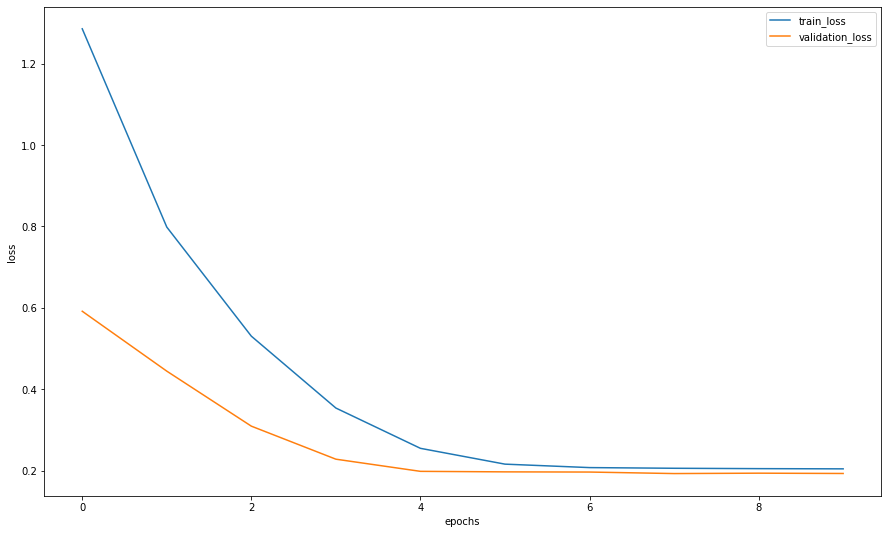

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_val, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Choose some images from validation dataset and show autoencoder's outputs on them

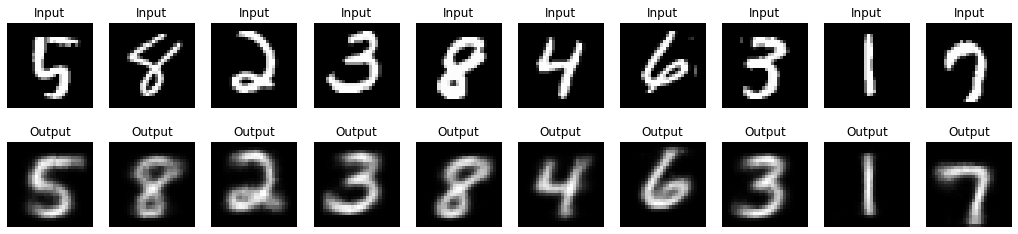

In [ ]:
data_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
X, label = next(iter(data_val))
label = F.one_hot(label, num_classes=10)

autoencoder.eval()
Y = autoencoder(X.to(device), label.to(device))[2].detach().to('cpu')

plt.figure(figsize=(18, 4))
for k in range(10):
            
    plt.subplot(2, 10, k+1)
    plt.imshow(X[k][0].numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')

    plt.subplot(2, 10, k+11)
    plt.imshow(Y[k][0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

### Generation


Now we will try to generate the images of different numbers from one and the same random vector from $\mathcal{N}(0,\,1)$. Just like in Part 2, it is possible to use mean mu and sigma of the whole dataset as the parameters for random vector's distribution

In [ ]:
whole_MNIST = train_set + val_set
data_gen = DataLoader(whole_MNIST, batch_size=batch_size, shuffle=True, num_workers=2)
mu_lst = []
logsigma_lst = []

for batch in data_gen:
    X, label = batch
    X = X.to(device)
    label = F.one_hot(label, num_classes=10).to(device)

    autoencoder.eval()
    mu, logsigma = autoencoder.encode(X, label)
    
    mu_lst.append(mu.detach())
    logsigma_lst.append(logsigma.detach())

In [ ]:
mean = torch.mean(torch.cat(mu_lst), dim=0)
logsigma = torch.mean(torch.cat(logsigma_lst), dim=0)
std = torch.exp(0.5 * logsigma)

In [ ]:
print(mean.size())
print(std.size())

torch.Size([256])
torch.Size([256])


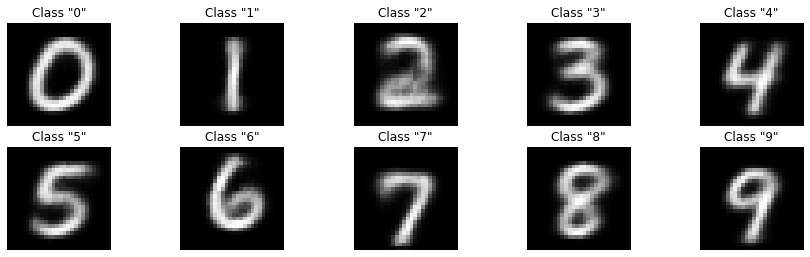

In [ ]:
label = [i for i in range(10)]

z = torch.cat(10 * [torch.randn(1, *mean.size()).to(device)])
label_ohe = F.one_hot(torch.tensor(label), num_classes=10)
# Uncomment the below to use the mean mu and sigma of the train dataset as the 
# parameters of distribution
# z = z * std + mean

autoencoder.eval()
output = autoencoder.decode(z.to(device), label_ohe.to(device)).detach().cpu()

plt.figure(figsize=(15, 11))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title(f'Class "{label[i]}"')
    plt.imshow(output[i][0], cmap='gray')
    plt.axis('off')
plt.show()

I think that the result is quite impressive, now all the numbers, generated from the same random vector, look like real ones

In [ ]:
del mu_lst, logsigma_lst
torch.cuda.empty_cache()

### Distribution of latent representations

Now we will look at the distribution of latent vectors, obtained from the whole validation dataset, using the same instruments, as in the previous part

In [ ]:
data_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
latent_codes = []
labels = []

for batch in data_val:
    X, label = batch
    X = X.to(device)
    label_ohe = F.one_hot(label.to(device), num_classes=10)

    autoencoder.eval()
    latent_code = autoencoder.encode(X, label_ohe)[0].detach().to('cpu').numpy()
    for v in latent_code:
      latent_codes.append(v)

    for l in label:
      labels.append(l.item())

In [ ]:
points = TSNE().fit_transform(latent_codes)

In [ ]:
clusters = {i: [] for i in range(10)}
for i, l in enumerate(labels):
    clusters[l].append(points[i])

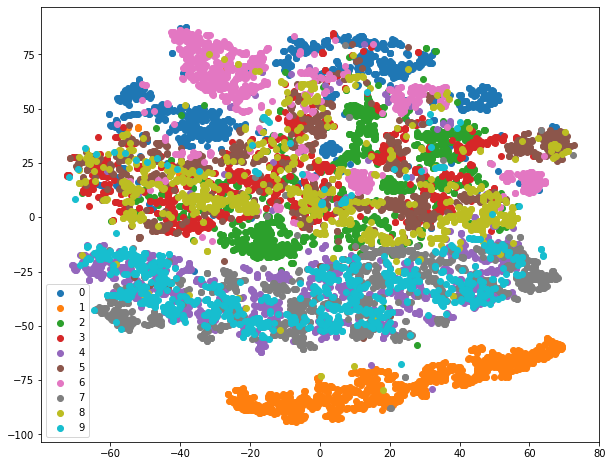

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter([p[0] for p in clusters[i]], [p[1] for p in clusters[i]], label=i)
plt.legend(loc='best')

It is seen that now the latent vectors of different classes are more densely packed, than they were for VAE. At the same time, the borders between classes became not so clear; there are lots of small islands of one class, surrounded by small islands of other classes. However, I do not think it implies that the results are bad, as both generation and reconstruction worked incomparably better, than in previous parts

# BONUS 1: Image Morphing (1 балл) 

Now we will transform one person (input, $X$) into another (target, $Y$). I will get the latent vectors for both people, and then visualize the images generated from their linear combinations $(1 - \alpha) X + \alpha Y$, varying $\alpha$ from 0 to 1. So, the first image will be the "only input"; the last one will be the "only target", whereas the intermediate pictures will show different transition stages of the transformation

For this task I will use the vanilla autoencoder, as it was already fitted and trained for the reconstruction of LFW dataset in part 1

### Architecture

In [ ]:
dim_code = 128

In [ ]:
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(vanilla_AE_params)

<All keys matched successfully>

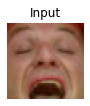

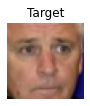

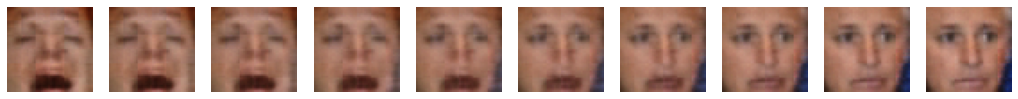

In [ ]:
# I did not reinitialized x_train and x_val, so there are the same datasets, as 
# in part 1
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(x_val, 3, 1))), 
                     batch_size=batch_size, shuffle=True)
X = next(iter(data_val))[0].to(device)
Y = next(iter(data_val))[0].to(device)

autoencoder.eval()
lat_X = autoencoder.encode(X).detach()
lat_Y = autoencoder.encode(Y).detach()

stages = 10

plt.figure(figsize=(1.4, 1.4))
plt.title('Input')
plt.axis('off')
plt.imshow((np.rollaxis(X[0].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
sleep(0.7)

plt.figure(figsize=(1.4, 1.4))
plt.title('Target')
plt.axis('off')
plt.imshow((np.rollaxis(Y[0].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
sleep(0.7)

plt.figure(figsize=(18, 4))
for k in np.arange(0, 1, 1/stages):
    ind = round(k * stages)
    mix = ((1 - k) * lat_X + k * lat_Y)
    hybrid = autoencoder.decode(mix).detach() 

    plt.subplot(1, stages, ind+1)
    plt.imshow((np.rollaxis(hybrid[0].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.axis('off')

# BONUS 2: Denoising (2 балла) 

Now we will train autoencoder to denoise pictures. For this task the vanilla autoencoder will be used, as its architecture was already fitted for the LFW dataset (however, it still should be trained for denoising)

### Prepare the data

Here, the dataset of the noisy pictures will be needed, so I will create it from the original dataset. All the other stages will be the same, as in the part 1

In [ ]:
noise_factor = 0.1
data_noisy = []

for i, pic in enumerate(data):
  data_noisy.append(pic + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=pic.shape)) 

In [ ]:
data_noisy = np.array(data_noisy, np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


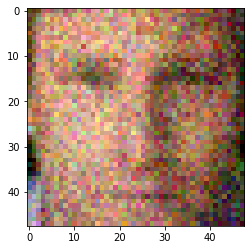

In [ ]:
plt.imshow(data_noisy[0])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data_noisy, data, test_size=0.2, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


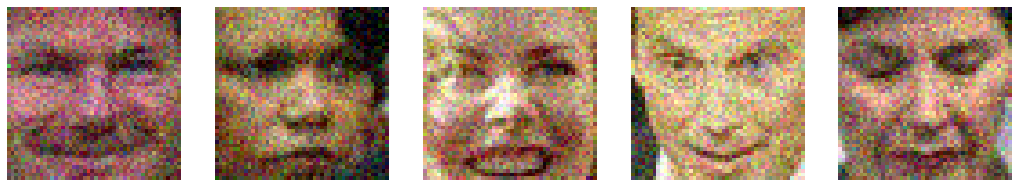

In [ ]:
inds = np.random.uniform(0, len(x_train), size=5)

plt.figure(figsize=(18, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_train[int(inds[i])])

In [ ]:
batch_size = 30

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(x_train, 3, 1), np.rollaxis(y_train, 3, 1))), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(y_val, 3, 1))), 
                     batch_size=batch_size, shuffle=True)

### Training

In [ ]:
criterion = nn.BCELoss()
autoencoder = Autoencoder().to(device)
opt = optim.AdamW(autoencoder.parameters())

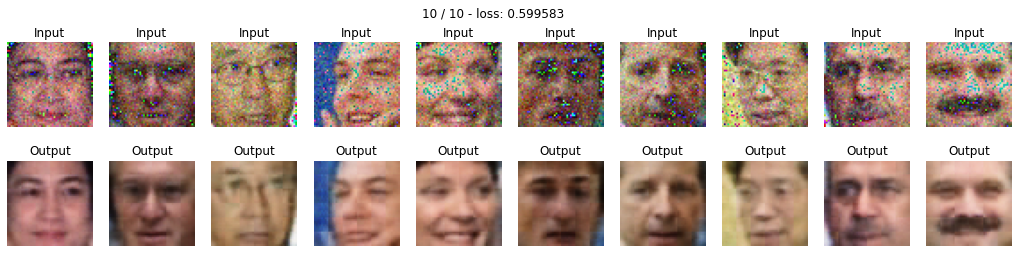

In [ ]:
loss_tr, loss_val, lcs = train_vanilla(autoencoder, opt, criterion, 10, data_tr, data_val)

The graph of losses

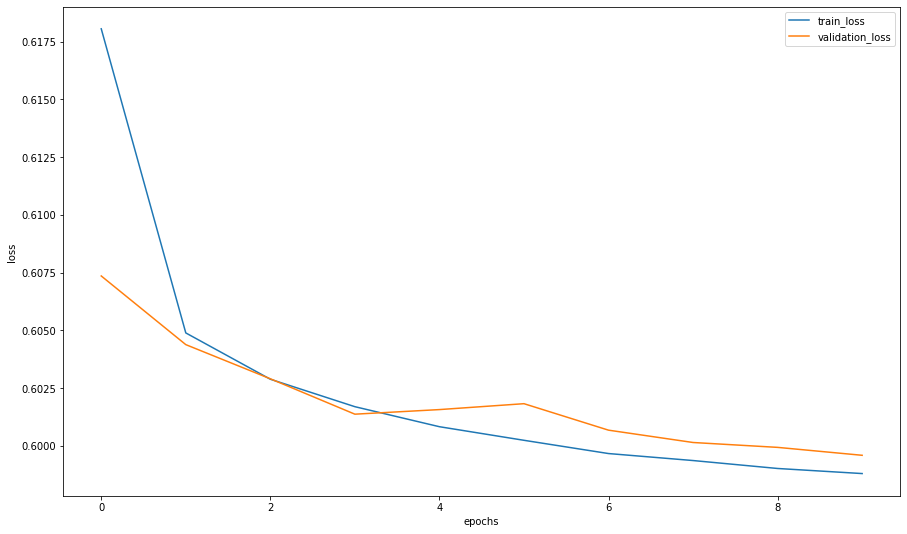

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_val, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Choose some images from validation dataset and show, how autoencoder denoises them

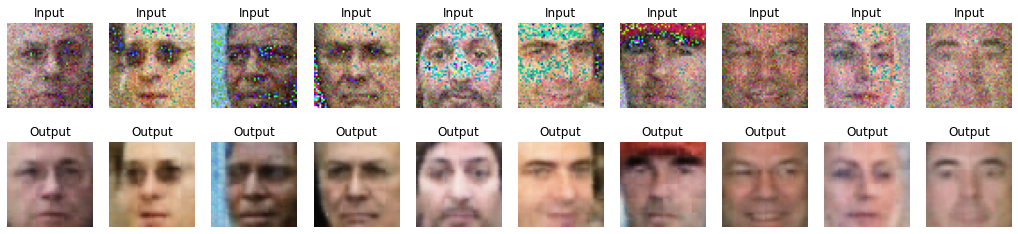

In [ ]:
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(y_val, 3, 1))), 
                     batch_size=batch_size, shuffle=True)
X = next(iter(data_val))[0].to(device)

autoencoder.eval()
Y = autoencoder(X)[0].detach()

plt.figure(figsize=(18, 4))
for k in range(10):
            
    plt.subplot(2, 10, k+1)
    plt.imshow((np.rollaxis(X[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.title('Input')
    plt.axis('off')

    plt.subplot(2, 10, k+11)
    plt.imshow((np.rollaxis(Y[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.title('Output')
    plt.axis('off')

In [ ]:
del data_noisy
torch.cuda.empty_cache()

## Бонус 2.1: Occlusion (+еще 1 балл)

In this point, we will recover pictures, part of which was covered by some mask. Except for the process of creating those masks, the algorithm will be the same, as for the denoising

### Prepare the data

In [ ]:
data_occluded = []

for pic in data:
  pic = torch.tensor(np.rollaxis(pic, 2, 0)) 
  
  h = 20
  w = 20
  pad_h = (48-h)//2
  pad_w = (48-w)//2

  # Looks monstrous, but it generates more or less different masks
  cutter = transforms.Compose([
      transforms.RandomCrop((h, w)),
      transforms.Pad((pad_h, pad_w)),
      transforms.Resize((48, 48)),
      transforms.RandomRotation(degrees=30),                          
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomCrop((h, w)),
      transforms.Pad((pad_h, pad_w)),
      transforms.Resize((48, 48)),
      transforms.RandomRotation(degrees=30),                          
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip()])

  mask = (cutter(torch.ones_like(pic)) == 0).float()

  data_occluded.append(np.rollaxis((pic * mask).numpy(), 0, 3))


In [ ]:
data_occluded = np.array(data_occluded, np.float32)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data_occluded, data, test_size=0.2, shuffle=True)

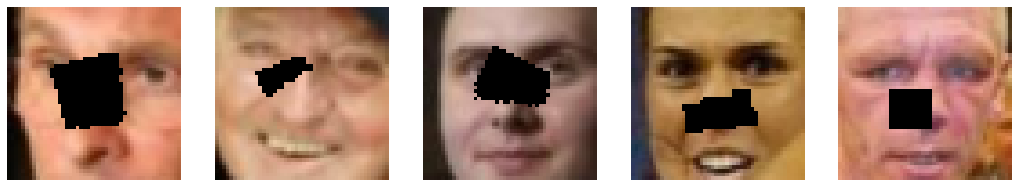

In [ ]:
inds = np.random.uniform(0, len(x_train), size=5)

plt.figure(figsize=(18, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_train[int(inds[i])])

In [ ]:
batch_size = 30

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(x_train, 3, 1), np.rollaxis(y_train, 3, 1))), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(y_val, 3, 1))), 
                     batch_size=batch_size, shuffle=True)

### Training

In [ ]:
criterion = nn.BCELoss()
autoencoder = Autoencoder().to(device)
opt = optim.AdamW(autoencoder.parameters())

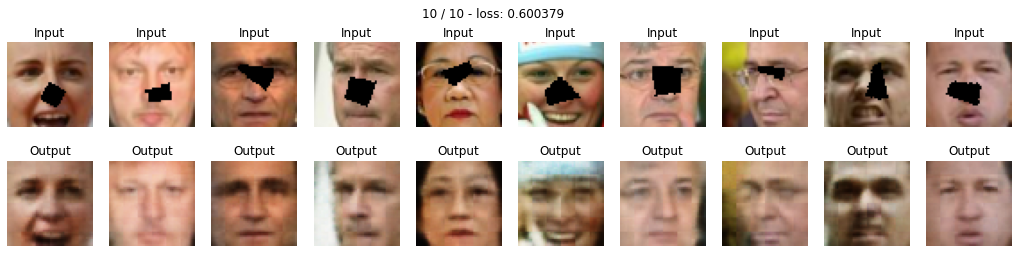

In [ ]:
loss_tr, loss_val, lcs = train_vanilla(autoencoder, opt, criterion, 10, data_tr, data_val)

The graph of losses

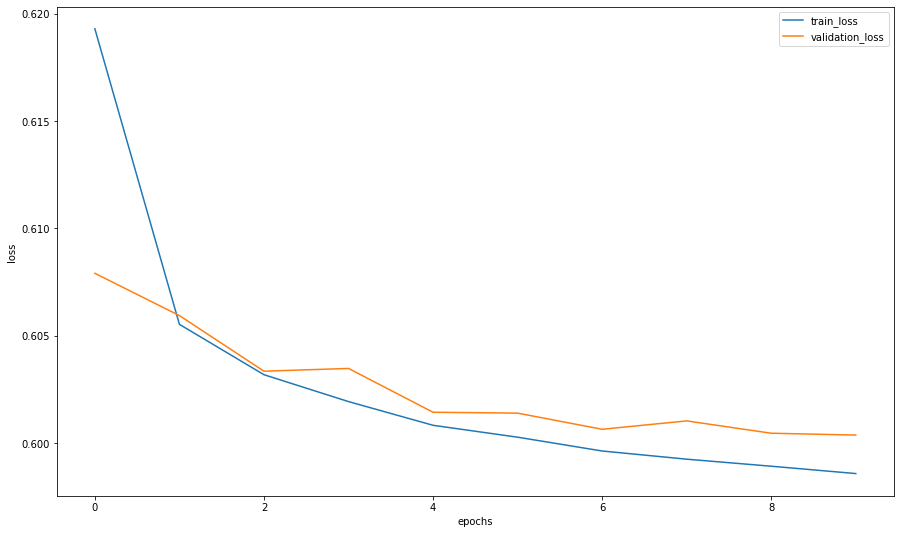

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_val, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Choose some images from validation dataset and show, how autoencoder reсovers them

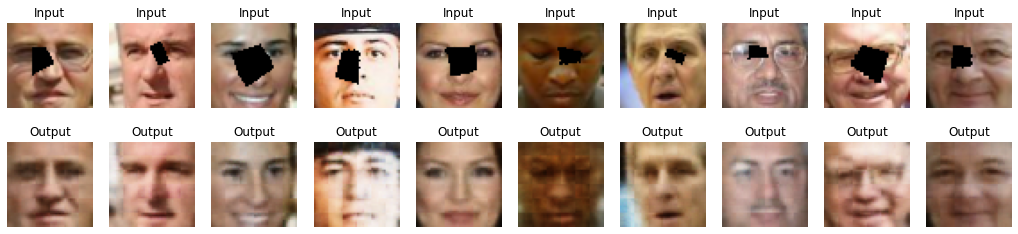

In [ ]:
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(y_val, 3, 1))), 
                     batch_size=batch_size, shuffle=True)
X = next(iter(data_val))[0].to(device)

autoencoder.eval()
Y = autoencoder(X)[0].detach()

plt.figure(figsize=(18, 4))
for k in range(10):
            
    plt.subplot(2, 10, k+1)
    plt.imshow((np.rollaxis(X[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.title('Input')
    plt.axis('off')

    plt.subplot(2, 10, k+11)
    plt.imshow((np.rollaxis(Y[k].to('cpu').numpy(), 0, 3) * 255).astype('uint8'))
    plt.title('Output')
    plt.axis('off')

In [ ]:
del data_occluded
torch.cuda.empty_cache()

# Bonus 3: Image Retrieval (1 балл)

In this task, we will find the closest (in terms of latent code) pictures for the given one. So, we need to get the latent codes for all pictures of the train dataset, then fit some sort of 'neighbor searcher' to them, and, finally, test it on some pictures from the validation dataset

Here we will use the same LFW dataset, as in the part 1, without any changes, and the vanilla autoencoder, pretrained on it

### Prepare the data

In [ ]:
x_train, x_val = train_test_split(data, test_size=0.2, shuffle=True)

In [ ]:
len(x_train)

10514

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(x_train, 3, 1), np.rollaxis(x_train, 3, 1))), 
                     batch_size=1, shuffle=False)
data_val = DataLoader(list(zip(np.rollaxis(x_val, 3, 1), np.rollaxis(x_val, 3, 1))), 
                     batch_size=1, shuffle=True)

### Architecture

In [ ]:
dim_code = 128

In [ ]:
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(vanilla_AE_params)

<All keys matched successfully>

### Neighbor searcher fitting

In [ ]:
codes = np.array([autoencoder.encode(X.to(device)).detach().to('cpu').numpy()[0] for X, _ in data_tr])

In [ ]:
print(codes.shape)

(10514, 4608)


In [ ]:
n = 5
nbrs = NearestNeighbors(n)
nbrs = nbrs.fit(codes)

### Testing

Function that returns images, which are the closest (in terms of latent code) to the provided one, and distances to them

In [ ]:
def get_similar(image, n_neighbors=n):

  image = torch.tensor(np.rollaxis(image, 2, 0)).unsqueeze(0)
  code = autoencoder.encode(image.to(device)).detach().to('cpu')
  (distances,), (idx,) = nbrs.kneighbors(code, n_neighbors)
  
  return distances, x_train[idx]

Function that visualizes the closest images to the given one and shows the distances between them

In [ ]:
def show_similar(image, n_neighbors=n):
    
    distances, neighbors = get_similar(image, n_neighbors)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(2, n, 1)
    plt.imshow(image)
    plt.title("Original image")
    plt.axis('off')
    
    for i in range(n_neighbors):
        plt.subplot(2, n, i+n+1)
        plt.imshow(neighbors[i])
        plt.title(f"Dist={np.around(distances[i], 3)}")
        plt.axis('off')
    plt.show()

    print()

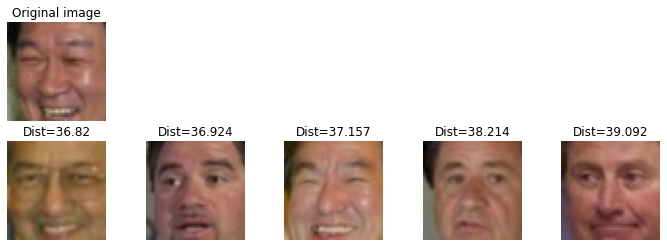

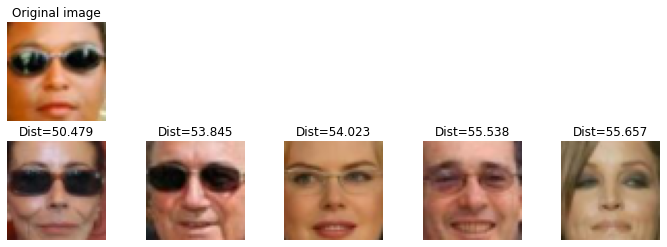

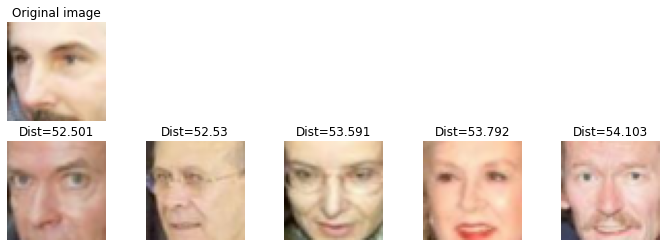

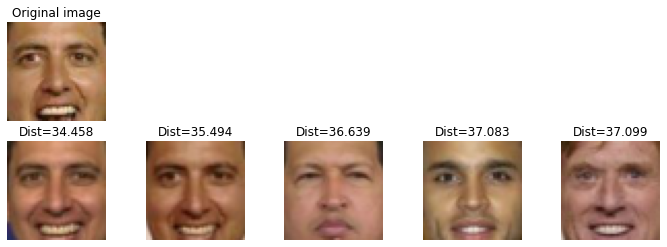

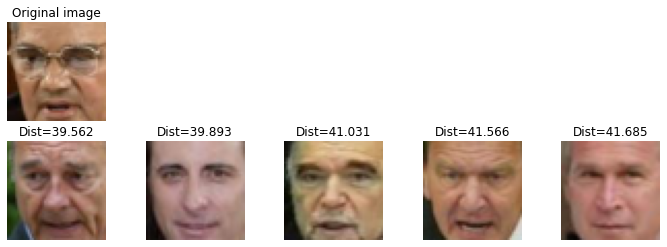

In [ ]:
ix = np.random.uniform(0, len(x_val), size=5)

for i in ix:
    image = x_val[int(i)]
    show_similar(image, n)

Some of them really look similar!